# Multi-class Classification with ResNet50 on CIFAR-100 using TensorFlow

In [1]:
!pip install tensorflow scikit-learn --quiet

### Import Required Libraries
- TensorFlow/Keras for building and training the CNN
- ImageDataGenerator for loading and augmenting image data
- Scikit-learn for handling class imbalance and evaluation metrics
- Matplotlib/Seaborn for visualizing the confusion matrix

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

### Load and Preprocess CIFAR-100 Dataset
- Load CIFAR-100 dataset using `tf.keras.datasets`

In [3]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [4]:
x_train.shape, x_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

### One-hot Encode Labels
- Convert label integers to one-hot encoded vectors for 100 classes

In [5]:
y_train_cat = to_categorical(y_train, 100)
y_test_cat = to_categorical(y_test, 100)

### Preprocessing
- Resize CIFAR images from 32×32 to 224×224 using `tf.image.resize`
- Normalize pixel values to range [0, 1]

In [6]:
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_cat))
train_ds = train_ds.map(preprocess).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_cat))
val_ds = val_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

### Load Pretrained ResNet50 Base Model
- Use `ResNet50` with `include_top=False` to exclude final dense layers.
- Unfreeze last few convolutional layers of ResNet50.

In [7]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model for feature extraction

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Add Custom Classification Head
- Add `GlobalAveragePooling2D` to reduce spatial dimensions.
- Add dense layer with ReLU and Dropout.
- Add softmax output layer for 10-class prediction.

In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(100, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

<img src="https://miro.medium.com/v2/resize:fit:1400/0*9LqUp7XyEx1QNc6A.png">

<img src="https://wisdomml.in/wp-content/uploads/2023/03/resnet_bannner.png">

In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,688,100 (94.18 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Compile the Model
- Use `Adam` optimizer with low learning rate.
- Set loss to `categorical_crossentropy`.
- Track accuracy as the evaluation metric.

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model (Feature Extraction)
- Train only the classification head with base ResNet50 frozen.
- Use `validation_split` to monitor validation performance.

In [11]:
history = model.fit(train_ds, validation_data=val_ds, epochs=1)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 194s 114ms/step - accuracy: 0.0097 - loss: 4.6333 - val_accuracy: 0.0100 - val_loss: 4.6052


### Unfreeze Layers for Fine-Tuning
- Unfreeze last few convolutional layers of ResNet50.
- Recompile with an even lower learning rate to avoid destroying pretrained weights.


In [12]:
### Unfreeze Some Layers for Fine-Tuning
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

### Continue Training (Fine-Tuning)
- Resume training with a few unfrozen layers to boost performance.

In [14]:
fine_tune_history = model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 215s 127ms/step - accuracy: 0.0116 - loss: 4.5942 - val_accuracy: 0.0243 - val_loss: 4.5297
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 249s 123ms/step - accuracy: 0.0268 - loss: 4.5150 - val_accuracy: 0.0460 - val_loss: 4.3991
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 202s 123ms/step - accuracy: 0.0427 - loss: 4.4247 - val_accuracy: 0.0764 - val_loss: 4.2796
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 202s 123ms/step - accuracy: 0.0607 - loss: 4.3140 - val_accuracy: 0.0891 - val_loss: 4.1540
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 177s 113ms/step - accuracy: 0.0743 - loss: 4.2027 - val_accuracy: 0.1118 - val_loss: 4.0312


### Evaluate the Model on Test Set
- Report final accuracy on test data.

In [15]:
test_loss, test_acc = model.evaluate(val_ds)
print(f"Test Accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 81ms/step - accuracy: 0.1139 - loss: 4.0281
Test Accuracy: 0.1118


In [ ]:
y_true = []
y_pred = []

for images, labels in val_ds:
    probs = model.predict(images)
    preds = np.argmax(probs, axis=1)
    y_pred.extend(preds)
    y_true.extend(np.argmax(labels.numpy(), axis=1))

### Generate Classification Report
- Predict test labels.
- Use `classification_report()` to show precision, recall, and F1-score.

In [17]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.19      0.48      0.28       100
           1       0.04      0.04      0.04       100
           2       0.00      0.00      0.00       100
           3       0.00      0.00      0.00       100
           4       0.00      0.00      0.00       100
           5       0.00      0.00      0.00       100
           6       0.00      0.00      0.00       100
           7       0.12      0.09      0.10       100
           8       0.10      0.07      0.08       100
           9       0.18      0.20      0.19       100
          10       0.04      0.04      0.04       100
          11       0.00      0.00      0.00       100
          12       0.10      0.06      0.07       100
          13       0.12      0.04      0.06       100
          14       0.05      0.03      0.04       100
          15       0.00      0.00      0.00       100
          16       0.23      0.21      0.22       100
          17       0.50    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Plot Confusion Matrix
- Compute and visualize confusion matrix to analyze misclassifications.

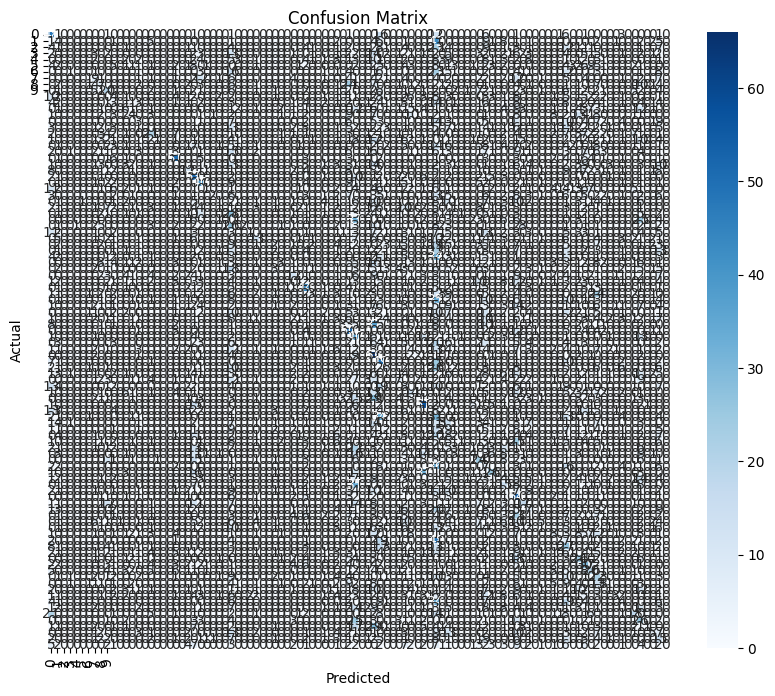

In [18]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()